In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import pandas as pd
from collections import defaultdict
import numpy as np
from numpy import unravel_index

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/Paten_lab/polishing/verkko_model/fp_kmer_vcfs_primates

mGorGor1_verkko_model2.deeppolisher.annotated_fixed_fp_kmers.vcf
mGorGor1_verkko_model2.deeppolisher.annotated_induced_fp_kmers.vcf
mGorGor1_verkko_model2.deeppolisher.annotated_neutral_fp_kmers.vcf
mGorGor1_verkko_model2.deeppolisher.annotated_unchanged_fp_kmers.vcf
mPanPan1_verkko_model2.deeppolisher.annotated_fixed_fp_kmers.vcf
mPanPan1_verkko_model2.deeppolisher.annotated_induced_fp_kmers.vcf
mPanPan1_verkko_model2.deeppolisher.annotated_neutral_fp_kmers.vcf
mPanPan1_verkko_model2.deeppolisher.annotated_unchanged_fp_kmers.vcf
mPanTro3_verkko_model2.deeppolisher.annotated_fixed_fp_kmers.vcf
mPanTro3_verkko_model2.deeppolisher.annotated_induced_fp_kmers.vcf
mPanTro3_verkko_model2.deeppolisher.annotated_neutral_fp_kmers.vcf
mPanTro3_verkko_model2.deeppolisher.annotated_unchanged_fp_kmers.vcf
mPonAbe1_verkko_model2.deeppolisher.annotated_fixed_fp_kmers.vcf
mPonAbe1_verkko_model2.deeppolisher.annotated_induced_fp_kmers.vcf
mPonAbe1_verkko_model2.deeppolisher.annotated_neutral_fp_kmers.v

In [5]:
def parse_vcf(vcf_path):
  records = []
  with open(vcf_path, "r") as f:
    for line in f:
      # skip header lines
      if line.startswith("#"): continue
      cols = line.strip().split()
      records.append(cols)
  return records

In [15]:
samples=["mGorGor1_verkko_model2",  "mPanTro3_verkko_model2", "mPonAbe1_verkko_model2","mPonPyg2_verkko_model2"]
vcf_dict = {}
base_path = "/content/drive/MyDrive/Paten_lab/polishing/verkko_model/fp_kmer_vcfs_primates"
for sample in samples:
  vcf_dict[sample] = {}
  vcf_dict[sample]["fixed"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_fixed_fp_kmers.vcf")
  vcf_dict[sample]["induced"] = parse_vcf(f"{base_path}/{sample}.deeppolisher.annotated_induced_fp_kmers.vcf")

In [16]:
vcf_dict["mGorGor1_verkko_model2"]["induced"][0]

['chr10_mat',
 '8142330',
 '.',
 'CA',
 'C',
 '4',
 'PASS',
 '.',
 'GT:GQ',
 '0/1:4',
 'chr10_mat',
 '8142325',
 '8142361',
 '5']

In [9]:
def get_q_count(kmer_vcf, only_insertion_one = False):
  kmer_q_count = np.zeros(100) # list containing number of kmers overlapping edits at GQ values from 0 to 40
  blocks = set()
  for rec in kmer_vcf:
    block = (rec[10], rec[11], rec[12]) # get FP kmer block
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    if block in blocks: continue
    q = rec[5] # GQ value at each record
    if q=="-2.14748e+09":
      q=0
    q=int(q)
    #if q>=40:
     # q=39

    kmer_count = int(rec[13]) # number of FP kmers in the given block
    len_rec = len(rec[4]) - len(rec[3]) # edit length
    # if the edit was 1bp insertion
    # and only_insertion_one was True
    if len_rec == 1 and only_insertion_one:
      kmer_q_count[q] += kmer_count
    elif only_insertion_one == False:
      kmer_q_count[q] += kmer_count
    blocks.add(block)
  return kmer_q_count

mGorGor1_verkko_model2


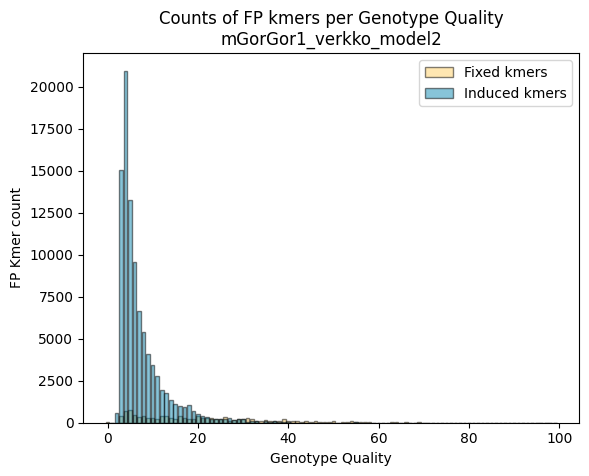

mPanTro3_verkko_model2


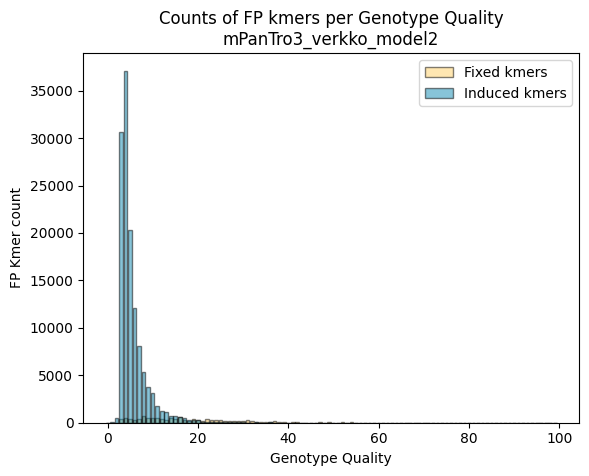

mPonAbe1_verkko_model2


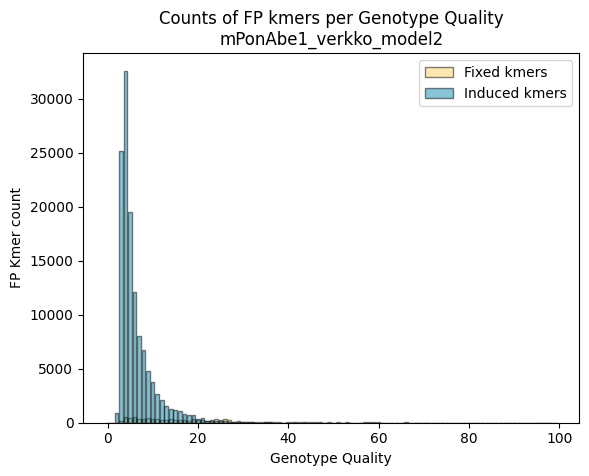

mPonPyg2_verkko_model2


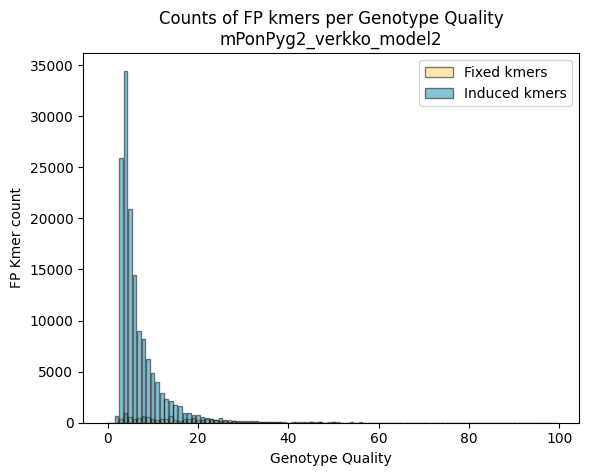

In [17]:
for sample in samples:
  print(sample)
  fixed_kmer_q_count = get_q_count(vcf_dict[sample]["fixed"], only_insertion_one = False)
  induced_kmer_q_count = get_q_count(vcf_dict[sample]["induced"], only_insertion_one = False)

  # Plotting a basic histogram
  plt.bar(np.arange(100), fixed_kmer_q_count,  color='#ffd166', edgecolor='black', alpha=0.5,label="Fixed kmers")
  plt.bar(np.arange(100), induced_kmer_q_count, color='#118ab2', edgecolor='black', alpha=0.5,label="Induced kmers")
  plt.title(f"Counts of FP kmers per Genotype Quality\n{sample}")
  plt.xlabel("Genotype Quality")
  plt.ylabel("FP Kmer count")
  plt.legend()


  #outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/verkko_model1_GQ_plots/" + sample + ".all_edits.png"
  #plt.savefig(outPNG,dpi=600)
  plt.show()

In [18]:
# Get fixed and induced kmer blocks

def get_fixed_induced_kmer_records(sample,vcf_dict):
  fixed_kmer_records = []
  blocks = set()
  for rec in vcf_dict[sample]["fixed"]:
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q=rec[5]
    if q=="-2.14748e+09":
      q=0
    q=int(q)
    kmer_count = int(rec[13])
    fixed_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  induced_kmer_records = []
  blocks = set()
  for rec in vcf_dict[sample]["induced"]:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q=rec[5]
    if q=="-2.14748e+09":
      q=0
    q=int(q)
    kmer_count = int(rec[13])
    induced_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  return fixed_kmer_records,induced_kmer_records

In [19]:
# read in list of # raw FP kmers in each sample

raw_FP_kmer_counts={}

with open(base_path + "/raw_fp_kmer_counts.csv") as kmer_csv:
  for line in kmer_csv:
    sample=line.strip().split(",")[0]
    count=int(line.strip().split(",")[1])
    raw_FP_kmer_counts[sample]=count

print(raw_FP_kmer_counts)

{'mGorGor1_verkko_model2': 735613, 'mPanPan1_verkko_model2': 2449987, 'mPanTro3_verkko_model2': 814662, 'mPonAbe1_verkko_model2': 810700, 'mPonPyg2_verkko_model2': 910669, 'mSymSyn1_verkko_model2': 464700}


In [20]:
# Combine FP kmers for all samples, calculate best QV improvements

fixed_kmer_records = []
induced_kmer_records = []
total_kmer_count=0

for sample in samples:

  # get fixed kmer records
  blocks = set()
  for rec in vcf_dict[sample]["fixed"]:
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])

    q=rec[5]
    if q=="-2.14748e+09":
      q=0
    q=int(q)
    kmer_count = int(rec[13])
    fixed_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  # get induced kmer records
  blocks = set()
  for rec in vcf_dict[sample]["induced"]:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    len_rec = len(rec[4]) - len(rec[3])
    q=rec[5]
    if q=="-2.14748e+09":
      q=0
    q=int(q)
    kmer_count = int(rec[13])
    induced_kmer_records.append((len_rec,q,kmer_count))
    blocks.add(block)

  total_kmer_count += raw_FP_kmer_counts[sample]

# get the best single GQ threshold
qv_changes = []
for q in range(0,35):
  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])
  #print(q,a,b)
  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)
  qv_changes.append(qv_change)
optimal_single_qv1=max(qv_changes)
optimal_single_gq=np.argmax(qv_changes)

print(f"Combining all FP kmers from all samples, the optimal single GQ threshold is {optimal_single_gq}")

# get the best INS-1, all other variants threshold
qv_changes_advanced = np.zeros((15,20))
for q1 in range(10,25):
  for q2 in range(0,20):
    a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
    b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

    a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
    b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

    qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)
    qv_changes_advanced[q1-10][q2-0] = qv_change

  max_qv_change = max(qv_changes_advanced.flatten())
  q1 , q2 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)

print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10} and all other variants is {q2}")

# get the best INS-1, DEL-1, and all other variants threshold
qv_changes_advanced = np.zeros((15,20,25))
for q1 in range(10,25):
  for q2 in range(0,20):
    for q3 in range(0,25):
      a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
      b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

      a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
      b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

      a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
      b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

      qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)
      qv_changes_advanced[q1-10][q2-0][q3-0] = qv_change

max_qv_change = max(qv_changes_advanced.flatten())
q1 , q2 , q3 = unravel_index(qv_changes_advanced.argmax(), qv_changes_advanced.shape)
print(f"Combining all FP kmers from all samples, the optimal INS-1 GQ threshold {q1+10}, DEL-1 GQ {q3} and all other variants is {q2}")

Combining all FP kmers from all samples, the optimal single GQ threshold is 21
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 24 and all other variants is 18
Combining all FP kmers from all samples, the optimal INS-1 GQ threshold 24, DEL-1 GQ 21 and all other variants is 13


In [21]:
print(f"For each sample, using a GQ threshold of {optimal_single_gq} we see QV improvement of: ")

q = 21
for sample in samples:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a = sum([rec[2] for rec in induced_kmer_records if rec[1] > q])
  b = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q])

  qv_change = -10 * np.log10((total_kmer_count + a - b) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a - b))

q1=24
q2=18

print(f"using INS-1 GQ cut off of {q1}, and {q2} for all other variants, we see a QV improvement of:")

for sample in samples:
  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 - b1 - b2) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a1 + a2 - b1 - b2))

q1=24
q2=13
q3=21

print(f"using INS-1 GQ cut off of {q1}, DEL-1 GQ cutoff of {q3} and {q2} for all other variants, we see a QV improvement of:")

for sample in samples:
  # get fixed and induced kmer records

  fixed_kmer_records,induced_kmer_records=get_fixed_induced_kmer_records(sample,vcf_dict)

  total_kmer_count = raw_FP_kmer_counts[sample]

  a1 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q1 and rec[0] == 1])
  b1 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q1 and rec[0] == 1])

  a2 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])
  b2 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q2 and rec[0] != 1 and rec[0] != -1 ])

  a3 = sum([rec[2] for rec in induced_kmer_records if rec[1] > q3 and rec[0] == -1])
  b3 = sum([rec[2] for rec in fixed_kmer_records if rec[1] > q3 and rec[0] == -1])

  qv_change = -10 * np.log10((total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3) / total_kmer_count)

  print(sample,qv_change,total_kmer_count - (total_kmer_count + a1 + a2 + a3 - b1 - b2 - b3))

For each sample, using a GQ threshold of 21 we see QV improvement of: 
mGorGor1_verkko_model2 0.011622496508540624 1966
mPanTro3_verkko_model2 0.014642195688775885 2742
mPonAbe1_verkko_model2 0.00595037863994298 1110
mPonPyg2_verkko_model2 0.00030045492713414346 63
using INS-1 GQ cut off of 24, and 18 for all other variants, we see a QV improvement of:
mGorGor1_verkko_model2 0.012895411113379893 2181
mPanTro3_verkko_model2 0.013155433431991397 2464
mPonAbe1_verkko_model2 0.008730014528170689 1628
mPonPyg2_verkko_model2 0.001845980117279535 387
using INS-1 GQ cut off of 24, DEL-1 GQ cutoff of 21 and 13 for all other variants, we see a QV improvement of:
mGorGor1_verkko_model2 0.012729615056209311 2153
mPanTro3_verkko_model2 0.013492316969709314 2527
mPonAbe1_verkko_model2 0.010426573841357 1944
mPonPyg2_verkko_model2 0.0034302371745206254 719


In [22]:
def get_edit_length_count(kmer_vcf, max_len):
  kmer_edit_length_count = np.zeros(max_len * 2)
  edit_length_array = np.arange(-max_len,max_len)
  blocks= set()
  for rec in kmer_vcf:
    # multiple polishing edit may have overlap with a single FP kmer block
    # so I exclude blocks that are already added to the kmer_q_count table
    block = (rec[10], rec[11], rec[12])
    if block in blocks: continue
    kmer_count = int(rec[13])
    len_rec = len(rec[4]) - len(rec[3])
    # if the length was larger than max_len
    # add their counts to the rightmost or leftmost bar
    if len_rec >= max_len: len_rec = max_len - 1
    if len_rec <= -max_len: len_rec =-max_len
    kmer_edit_length_count[len_rec + max_len] += kmer_count
    blocks.add(block)
  return edit_length_array, kmer_edit_length_count

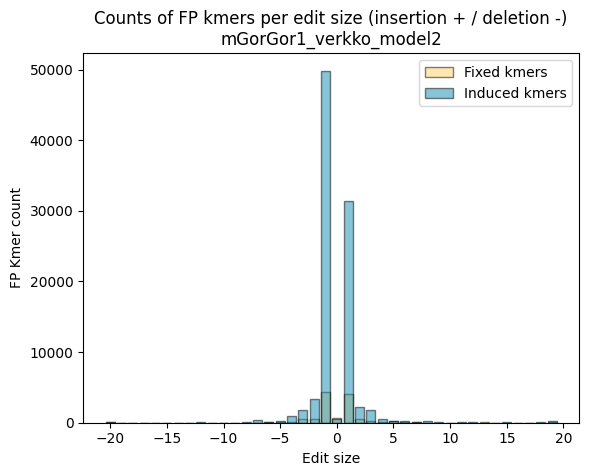

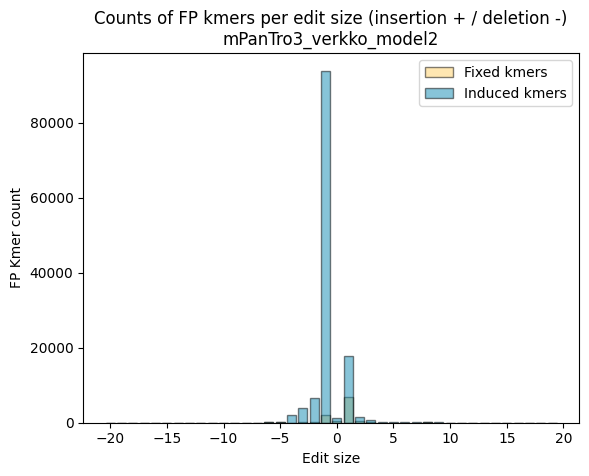

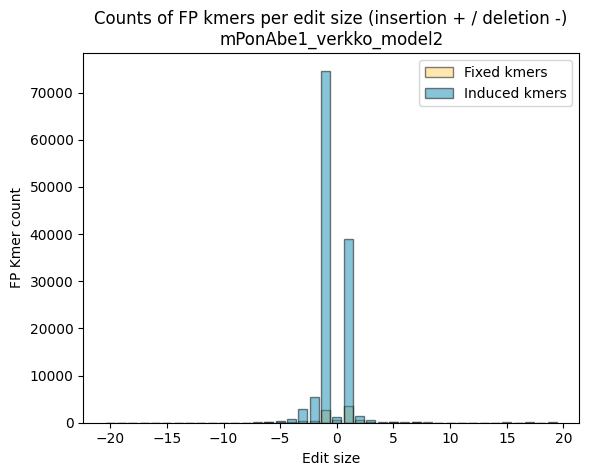

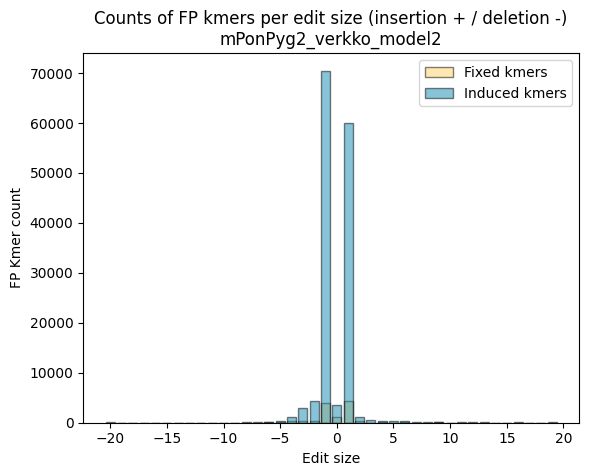

In [23]:
# Plot counts of FP kmers per edit size
for sample in samples:

  fixed_edit_length_array, fixed_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["fixed"], max_len=20)
  induced_edit_length_array, induced_kmer_edit_length_count = get_edit_length_count(vcf_dict[sample]["induced"], max_len=20)

  plt.bar(fixed_edit_length_array, fixed_kmer_edit_length_count ,  edgecolor='black', color='#ffd166', alpha=0.5,label="Fixed kmers")
  plt.bar(induced_edit_length_array, induced_kmer_edit_length_count ,  edgecolor='black', color='#118ab2', alpha=0.5,label="Induced kmers")

  plt.title(f"Counts of FP kmers per edit size (insertion + / deletion -)\n{sample}")
  plt.xlabel("Edit size")
  plt.ylabel("FP Kmer count")
  plt.legend()
  #outPNG="/content/drive/MyDrive/Paten_lab/polishing/HPRC_int_asm/verkko_optimize_GQ_plots/edit_lengths" + sample + ".png"
  #plt.savefig(outPNG,dpi=600)
  plt.show()